# Training script for semantic segmentation of: Random Forests, SupportVectorMachine, and Logistic Regression
## How to run this script
### 1) Change "%cd ..." to the proper directory consistent to your environment 

## Import Libraries 

In [2]:
import os
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import io
import shutil
import re 
import time

import scipy.interpolate
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

from skimage.filters import sobel
from scipy import ndimage as nd
from scipy.ndimage.filters import laplace

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.INFO) # INFO # WARNING # ERROR

tf.logging.set_verbosity(tf.logging.INFO)


RANDOM_SEED = 8675309
ZFILL=8

TARGET_WIDTH=256
TARGET_HEIGHT=256

## Familiarize, Visualize, and Use the Dataset 
### Auxiliary functions

In [3]:
DATASETS_DIR = r"../datasets"
ADE_DIR = os.path.join(DATASETS_DIR, r"ADE")

CLASS_INVALID=0


def convert_grayscale(image):
    ''' BGR to grayscale '''
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def interpolate_label(label):
    ''' Interpolate the label to fill invalid nodes with the nearest neighbor '''
    mask = (label != CLASS_INVALID)
    if np.count_nonzero(mask) == 0:
        return label # The entire label is invalid node
    xx, yy = np.meshgrid(np.arange(label.shape[1]), np.arange(label.shape[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T

    # Get valid class ids
    valid_class_ids = np.ravel(label[:,:][mask] )
    # Interpolate
    interp = scipy.interpolate.NearestNDInterpolator( xym, valid_class_ids )
    # Reshape to the 2D matrix
    interpolated_label = interp(np.ravel(xx), np.ravel(yy)).reshape( xx.shape )
    interpolated_label = interpolated_label.astype(np.uint16)
    
    # Assert that there are no more invalid pixels
    assert(np.count_nonzero(interpolated_label==0)==0)
    return interpolated_label


def get_image(instance, dataset):
    ''' Return the image given the instance and dataset directory '''
    dataset_name = os.path.basename(dataset)
    image_dir = os.path.join(dataset, r"images")
    filename = "{}_{}.{}".format(dataset_name, str(instance).zfill(ZFILL), "jpg")
    filepath = os.path.join(image_dir, filename)
    return cv2.imread(filepath)


def get_label(instance, dataset):
    ''' Get a interpolated label from an instance as a npy matrix of shape [height, width] '''
    labels_dir = os.path.join(dataset, r"labels") 
    dataset_name = os.path.basename(dataset)
    filename = "{}_{}.{}".format(dataset_name, str(instance).zfill(ZFILL), "npy")
    label = np.load(os.path.join(labels_dir, filename))
    normalized_label = interpolate_label(label)
    return normalized_label
    #return label


def crop_bottom_center(image):
    ''' Crop the image to a square by the bottom center. This normalizes our input to a fixed shape '''
    y,x = image.shape[0], image.shape[1]
    new_size = min(x, y)
    start_x = x//2-(new_size//2)
    start_y = y-new_size
    return image[start_y:start_y+new_size, start_x:start_x+new_size]


def get_normalized_image(instance, dataset, target_width, target_height):
    ''' Use Bilinear Interpolation to resize the original image to the target dimension. This normalizes our input to a fixed size '''
    image = get_image(instance=instance, dataset=dataset)
    cropped_image = crop_bottom_center(image)
    normalized_image = cv2.resize(cropped_image, dsize=(target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return normalized_image
    
    
def get_normalized_label(instance, dataset, target_width, target_height):
    ''' Use Nearest Neighbor Interpolation to resize the label image to the target dimension '''
    label = get_label(instance, dataset)
    cropped_label = crop_bottom_center(label)
    normalized_label = cv2.resize(cropped_label, dsize=(target_width, target_height), interpolation=cv2.INTER_NEAREST)        
    return normalized_label
        

def display_metrics(name,
                    true_positives,
                    true_negatives,
                    false_positives,
                    false_negatives,
                    pixel_accuracy,
                    recall,
                    precision,
                    jaccard,
                    roc_auc):
    
    print("{} True Positive on the test dataset = {}".format(name, true_positives))
    print("{} True Negative on the test dataset = {}".format(name, true_negatives))
    print("{} False Positive on the test dataset = {}".format(name, false_positives))
    print("{} False Negative on the test dataset = {}".format(name, false_negatives))
    print("{} Pixel Accuracy on the test dataset = {}".format(name, pixel_accuracy))
    print("{} Recall on the test dataset = {}".format(name, recall))
    print("{} Precision on the test dataset = {}".format(name, precision))
    print("{} Jaccard Score on the test dataset = {}".format(name, jaccard))
    print("{} ROC AUC on the test dataset = {}".format(name, roc_auc))
    
    '''
    cm_mobilenet_etpu = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]])
    '''
    cm_mobilenet_etpu = np.array([
        [true_negatives, false_positives],
        [false_negatives, true_positives]])
    ls = [0, 1] # your y labels
    disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm_mobilenet_etpu), display_labels=ls)
    fig, ax = plt.subplots(figsize=(2,2))
    ax.set_title(name)
    disp.plot(ax=ax)
    
def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [203, 206, 145]
    colormap[1] = [234, 115, 141]
    colormap[2] = [70, 70, 70]
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = create_cityscapes_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')
    
    return colormap[label]

## Create a dataframe and fill it with Features
### The features are imputated data from various filters: grayscale, cannyedge, sobel, laplace, gaussian, median, and gabor.
### Other features of importance are row and column of the pixel (as floors tend to be at the bottom of the image)

In [4]:
DATASETS_DIR = r"../datasets"
ADE_DIR = os.path.join(DATASETS_DIR, r"ADE")
CLASS_INVALID=0
CLASS_FLOOR = 4 # ADE Floor Id is 4
CLASS_RUG = 29
CLASS_INDOOR_WALKABLE_DUMMY = 255

CLASS_INDOOR_WALKABLE = 0
CLASS_INDOOR_NONWALKABLE = 1

T1=100 # Experiment with lower values for Canny_edge filter
T2=300 # Experiment with upper values for Canny_edge filter

def create_rgbgray(normalized_image, normalized_image_reshaped, normalized_image_gray):    
    ''' RGB (or rather BGR) to grayscale imputate data '''
    normalized_image_gray_reshaped = normalized_image_gray.reshape((normalized_image_gray.shape[0]*normalized_image_gray.shape[1], -1))
    assert(normalized_image_reshaped.ndim == 2)
    assert(normalized_image_reshaped.shape[1] == 3)
    assert(normalized_image_gray_reshaped.ndim == 2)
    assert(normalized_image_gray_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == normalized_image_gray_reshaped.shape[0])
    rgbgray = np.column_stack((normalized_image_reshaped,normalized_image_gray_reshaped))
    return rgbgray

    
def create_edge_canny(normalized_image, normalized_image_reshaped, normalized_image_gray, t1, t2):
    ''' Edge canny imputate data '''
    edges_canny = cv2.Canny(image=normalized_image, threshold1=t1, threshold2=t2)
    edges_canny_reshaped = edges_canny.reshape((edges_canny.shape[0]*edges_canny.shape[1],-1))
    assert(edges_canny_reshaped.ndim == 2)
    assert(edges_canny_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == edges_canny_reshaped.shape[0])
    return edges_canny_reshaped[:, -1]


def create_sobel(normalized_image, normalized_image_reshaped, normalized_image_gray):    
    ''' Sobel imputate data '''
    edges_sobel = sobel(image=normalized_image_gray)
    edges_sobel_reshaped = edges_sobel.reshape((edges_sobel.shape[0]*edges_sobel.shape[1],-1))
    assert(edges_sobel_reshaped.ndim == 2)
    assert(edges_sobel_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == edges_sobel_reshaped.shape[0])
    return edges_sobel_reshaped[:, -1]


def create_laplace(normalized_image, normalized_image_reshaped, normalized_image_gray, mode):
    ''' Laplace imputate data '''
    laplace_reflect = laplace(input=normalized_image_gray, mode=mode)
    laplace_reflect_reshaped = laplace_reflect.reshape((laplace_reflect.shape[0]*laplace_reflect.shape[1],-1))
    assert(laplace_reflect_reshaped.ndim == 2)
    assert(laplace_reflect_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == laplace_reflect_reshaped.shape[0])
    return laplace_reflect_reshaped[:, -1]


def create_gaussian(normalized_image, normalized_image_reshaped, normalized_image_gray, sigma):
    ''' Gaussian imputate data '''
    gaussian = nd.gaussian_filter(normalized_image_gray, sigma=sigma)
    gaussian_reshaped = gaussian.reshape((gaussian.shape[0]*gaussian.shape[1],-1))
    assert(gaussian_reshaped.ndim == 2)
    assert(gaussian_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == gaussian_reshaped.shape[0])
    return gaussian_reshaped[:, 0]


def create_median(normalized_image, normalized_image_reshaped, normalized_image_gray, size):
    ''' Median imputate data '''
    median = nd.median_filter(normalized_image_gray, size=size)
    median_reshaped = median.reshape((median.shape[0]*median.shape[1],-1))
    assert(median_reshaped.ndim == 2)
    assert(median_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == median_reshaped.shape[0])
    return median_reshaped[:, 0]


def create_gabor(normalized_image_gray_reshaped):
    ''' Gabor imputate data '''
    # Credits: https://github.com/bnsreenu/python_for_microscopists/blob/master/061-Gabor_Filter_Banks.py
    #Generate Gabor features
    gabor_col = None
    num = 0  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []  #Create empty list to hold all kernels that we will generate in a loop
    for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with values of 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5                    
                    ##gabor_label = 'gabor_' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(normalized_image_gray_reshaped, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    
                    if gabor_col is None:
                        gabor_col = filtered_img
                    else:
                        gabor_col = np.column_stack((gabor_col,filtered_img))
                        
                    ##print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    ##num += 1  #Increment for gabor column label
    
    assert(gabor_col.ndim == 2)
    assert(gabor_col.shape[0] == gabor_col.shape[0])
    return gabor_col


def create_rowcol(normalized_image):
    ''' Row and Col imputate data '''
    num_rows = normalized_image.shape[0]
    num_cols = normalized_image.shape[1]
    row = np.arange(num_rows)
    row = np.tile(row,(num_cols,1))
    row = row.T
    row = row.flatten()
    col = np.arange(num_cols)
    col = np.tile(col,(num_rows,1))
    col = col.flatten()
    assert(normalized_image.shape[0]*normalized_image.shape[1] == row.shape[0])
    assert(normalized_image.shape[0]*normalized_image.shape[1] == col.shape[0])
    rowcol = np.column_stack((row,col))
    return rowcol
  

def create_target_class(normalized_image, normalized_image_reshaped, normalized_label):
    ''' Target class: Walkable and Unwalkable '''
    # Naive Labels
    normalized_label[normalized_label == CLASS_FLOOR] = CLASS_INDOOR_WALKABLE_DUMMY
    normalized_label[normalized_label == CLASS_RUG] = CLASS_INDOOR_WALKABLE_DUMMY
    normalized_label[normalized_label != CLASS_INDOOR_WALKABLE_DUMMY] = CLASS_INDOOR_NONWALKABLE
    normalized_label[normalized_label == CLASS_INDOOR_WALKABLE_DUMMY] = CLASS_INDOOR_WALKABLE
    normalized_label_reshaped = normalized_label.reshape((normalized_label.shape[0]*normalized_label.shape[1], -1))
    assert(normalized_label_reshaped.ndim == 2)
    assert(normalized_label_reshaped.shape[1] == 1)
    assert(normalized_image_reshaped.shape[0] == normalized_label_reshaped.shape[0])
    return normalized_label_reshaped[:, 0]


def create_instance(instance, dataset):
    ''' Given an instance, create its imputated data '''
    normalized_image = get_normalized_image(instance=instance,
                                    dataset=dataset, 
                                    target_width=TARGET_WIDTH,
                                    target_height=TARGET_HEIGHT)
    normalized_image_reshaped = normalized_image.reshape((normalized_image.shape[0]*normalized_image.shape[1], -1))
    normalized_image_gray = convert_grayscale(image=normalized_image)
    normalized_image_gray_reshaped = normalized_image_gray.reshape((normalized_image_gray.shape[0]*normalized_image_gray.shape[1], -1))
    
    rgbgray_col = create_rgbgray(normalized_image, 
                            normalized_image_reshaped,
                            normalized_image_gray)
    rowcol_col = create_rowcol(normalized_image)
    edge_canny_col = create_edge_canny(normalized_image, 
                            normalized_image_reshaped,
                            normalized_image_gray,
                            t1=T1, t2=T2)
    sobel_col = create_sobel(normalized_image, 
                         normalized_image_reshaped,
                         normalized_image_gray)
    laplace_reflect_col = create_laplace(normalized_image, 
                                     normalized_image_reshaped,
                                     normalized_image_gray,
                                     mode="reflect")
    gaussian_3_col = create_gaussian(normalized_image, 
                                normalized_image_reshaped,
                                normalized_image_gray,
                                sigma=3)
    gaussian_7_col = create_gaussian(normalized_image, 
                                normalized_image_reshaped,
                                normalized_image_gray,
                                sigma=7)
    median_4_col = create_median(normalized_image, 
                                normalized_image_reshaped,
                                normalized_image_gray,
                                size=4)
    median_16_col = create_median(normalized_image, 
                                normalized_image_reshaped,
                                normalized_image_gray,
                                size=16)
    gabor_col = create_gabor(normalized_image_gray)
    
    normalized_label = get_normalized_label(instance=instance,
                                    dataset=dataset, 
                                    target_width=TARGET_WIDTH,
                                    target_height=TARGET_HEIGHT)           
    target_class_col = create_target_class(normalized_image, normalized_image_reshaped, normalized_label)
    
    instance_np = np.column_stack((rgbgray_col,
                                   rowcol_col,
                                   edge_canny_col,
                                   sobel_col,
                                   laplace_reflect_col,
                                   gaussian_3_col,
                                   gaussian_7_col,
                                   median_4_col,
                                   median_16_col,
                                   gabor_col,
                                   target_class_col,
                                  ))
    return instance_np


def convert_np_to_df(master_np):
    ''' Convert our multidimensional numpy array to a sensible dataframe with proper names for columns '''
    df = pd.DataFrame(master_np, columns = ["red","green","blue", "gray",
                                              "row", "col",
                                              "canny",
                                              "sobel",
                                              "laplace_reflect",
                                              "gaussian_3", "gaussian_7",
                                              "median_4", "median_16",
                                              "gabor_0", "gabor_1", "gabor_2", "gabor_3", 
                                              "gabor_4", "gabor_5", "gabor_6", "gabor_7", 
                                              "gabor_8", "gabor_9", "gabor_10", "gabor_11", 
                                              "gabor_12", "gabor_13", "gabor_14", "gabor_15",
                                              "gabor_16", "gabor_17", "gabor_18", "gabor_19",
                                              "gabor_20", "gabor_21", "gabor_22", "gabor_23",
                                              "gabor_24", "gabor_25", "gabor_26", "gabor_27",
                                              "gabor_28", "gabor_29", "gabor_30", "gabor_31",
                                              "class"
                                             ])

    df = df.astype({"red":np.uint8, "green":np.uint8, "blue":np.uint8, "gray":np.uint8,
                    "row":int, "col":int,
                    "canny":np.uint8,
                    "sobel":float,
                    "laplace_reflect":np.uint8,
                    "gaussian_3":np.uint8, "gaussian_7":np.uint8,
                    "median_4":np.uint8, "median_16":np.uint8,
                    "gabor_0":np.uint8, "gabor_1":np.uint8, "gabor_2":np.uint8, "gabor_3":np.uint8, 
                    "gabor_4":np.uint8, "gabor_5":np.uint8, "gabor_6":np.uint8, "gabor_7":np.uint8, 
                    "gabor_8":np.uint8, "gabor_9":np.uint8, "gabor_10":np.uint8, "gabor_11":np.uint8, 
                    "gabor_12":np.uint8, "gabor_13":np.uint8, "gabor_14":np.uint8, "gabor_15":np.uint8,
                    "gabor_16":np.uint8, "gabor_17":np.uint8, "gabor_18":np.uint8, "gabor_19":np.uint8,
                    "gabor_20":np.uint8, "gabor_21":np.uint8, "gabor_22":np.uint8, "gabor_23":np.uint8,
                    "gabor_24":np.uint8, "gabor_25":np.uint8, "gabor_26":np.uint8, "gabor_27":np.uint8,
                    "gabor_28":np.uint8, "gabor_29":np.uint8, "gabor_30":np.uint8, "gabor_31":np.uint8,
                    "class":np.uint8})

    return df

In [41]:
def save_dataframe(df, dataset_dir, filename, index=False):
    ''' Save dataframe '''
    dataframes_dir = os.path.join(dataset_dir, "dataframes")     
    df.to_csv(os.path.join(dataframes_dir, filename), index=index)

    
def load_dataframe(filename, dataset_dir, header=None, sep=',', index_col=0):
    ''' Load dataframe '''
    dataframes_dir = os.path.join(dataset_dir, "dataframes")     
    return pd.read_csv(os.path.join(dataframes_dir, filename), header=header, sep=sep, index_col=index_col, lineterminator='\n')


def create_ADE_indoor_df():
    ''' Create an indoor only ADE dataframe from the original ADE master dataframe and save it '''
    df_ade = load_dataframe(filename="ADE_master.csv", dataset_dir=ADE_DIR, header=0, index_col=None)

    print(df_ade.shape[0])

    # Indoor
    has_wall = df_ade['wall'] > 0.0
    print(has_wall.sum())

    has_floor = df_ade['floor'] > 0.0
    print(has_floor.sum())

    has_wall_or_floor = np.logical_or(has_wall, has_floor)
    print(has_wall_or_floor.sum())

    wall_more_sky = df_ade['wall'] > df_ade['sky']
    print(wall_more_sky.sum())

    indoor = np.logical_or(wall_more_sky, has_floor)
    print("Indoor: {}".format(indoor.sum()))

    df_indoor = df_ade[indoor]
    save_dataframe(df=df_indoor, dataset_dir=ADE_DIR, filename="ADE_indoor.csv")
    
# create_ADE_indoor_df()


In [5]:
def convert_misc_scene(df):
    ''' Fix the case where there is only one instance of a scene. We need at least 2 for stratified sampling. So consolidate the stragglers under one 'misc' value '''
    scene_counts = df['scene'].value_counts(dropna=False)
    mask = (scene_counts == 1)
    single_scenes = scene_counts[mask].index
    df['scene'] = df['scene'] .map(lambda x : x if x not in single_scenes else 'misc')
    return df


TRAIN_SIZE = 0.80
def create_train_val_test_instances(df, training_environment_dir, train_size):
    ''' Create a text file listing the randomized, stratified, sampling instances for train, validation, and test'''
    df = convert_misc_scene(df)
    train_df, other_df = train_test_split(df, stratify=df['scene'], test_size=1-TRAIN_SIZE, shuffle=True, random_state=RANDOM_SEED)

    other_df = convert_misc_scene(other_df)
    val_df, test_df = train_test_split(other_df, stratify=other_df['scene'], test_size=0.5, shuffle=True, random_state=RANDOM_SEED)
    
    train_instance_names = []
    for instance in (train_df.loc[:, ['id', 'dataset']]).itertuples():
        train_instance_names.append(instance.id)

    val_instance_names = []
    for instance in (val_df.loc[:, ['id', 'dataset']]).itertuples():
        val_instance_names.append(instance.id)
        
    test_instance_names = []
    for instance in (test_df.loc[:, ['id', 'dataset']]).itertuples():
        test_instance_names.append(instance.id)
        
    train_instance_names = sorted(train_instance_names)
    val_instance_names = sorted(val_instance_names)
    train_val_instance_names = sorted(train_instance_names + val_instance_names)
    test_instance_names = sorted(test_instance_names)
    
    print("Training instances: {}".format(len(train_instance_names)))
    print("Validation instances: {}".format(len(val_instance_names)))
    print("TrainVal instances: {}".format(len(train_val_instance_names)))
    print("Test instances: {}".format(len(test_instance_names)))

    return train_instance_names, val_instance_names, train_val_instance_names, test_instance_names

def create_df(instances, num_instances):
    ''' Create our new df with imputated filtering features '''
    master_np = None
    
    i=0
    for instance in instances:
        # Concatenate instances
        if master_np is None:
            master_np = create_instance(instance=instance, dataset=ADE_DIR)
        else:
            master_np = np.concatenate((master_np, create_instance(instance=instance, dataset=ADE_DIR)))
            
        i += 1
        if i >= num_instances:
            break
    
    df = convert_np_to_df(master_np)
    return df


## Create Data (256 Images of resolution 256x256 yielded a 3.1GB dataset in the form of a stored in the form of a .csv dataframe)

In [54]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")

%cd G:\segmentation_master\notebooks

def create_train_val_test_dataframes():
    ''' Create the dataframe based on a list of instances in for train, val, and test '''
    df_ade_indoor = load_dataframe(filename="ADE_indoor.csv", dataset_dir=ADE_DIR, header=0, index_col=None)
    print(df_ade_indoor.head())
    
    train_instances, val_instances, train_val_instances, test_instances = create_train_val_test_instances(df=df_ade_indoor, training_environment_dir=RF_ADE_INDOOR_ENVIRONMENT_DIR, train_size=TRAIN_SIZE)
    
    # Create train dataframe
    start = time.time()
    train_df = create_df(train_instances, 256)    
    train_df.to_csv(os.path.join(DATAFRAMES, "train_256.csv"), index=None)
    print(train_df.head())
    end = time.time()
    print("Time elapsed: {}".format(end-start)) # 21.3271164894104 seconds for 16 at 257x257,  555.5202133655548 seconds for 256
    
    # Create validation dataframe
    start = time.time()
    val_df = create_df(val_instances, 256)    
    val_df.to_csv(os.path.join(DATAFRAMES, "val_256.csv"), index=None)
    print(val_df.head())
    end = time.time()
    print("Time elapsed: {}".format(end-start)) # 44.59874510765076 seconds for 32
    
    # Create test dataframe
    start = time.time()
    test_df = create_df(test_instances, 256)      
    test_df.to_csv(os.path.join(DATAFRAMES, "test_256.csv"), index=None)
    print(test_df.head())
    end = time.time()
    print("Time elapsed: {}".format(end-start)) # 44.59874510765076 seconds for 32

    
def run_create_train_val_test_dataframes():
    create_train_val_test_dataframes()
    
    
df_ade_indoor = load_dataframe(filename="ADE_indoor.csv", dataset_dir=ADE_DIR, header=0, index_col=None)
print(df_ade_indoor.head())
    
train_instances, val_instances, train_val_instances, test_instances = create_train_val_test_instances(df=df_ade_indoor, training_environment_dir=RF_ADE_INDOOR_ENVIRONMENT_DIR, train_size=TRAIN_SIZE)
    
# Create test dataframe
start = time.time()
test_df = create_df(test_instances, 1)      
test_df.to_csv(os.path.join(DATAFRAMES, "test_1.csv"), index=None)
print(test_df.head())
end = time.time()
print("Time elapsed: {}".format(end-start)) # 44.59874510765076 seconds for 32


# Already ran and saved dataset, no need to rerun
#run_create_train_val_test_dataframes()

G:\segmentation_master\notebooks
   index  id dataset  width  height             scene   invalid      wall  \
0      0   0     ADE    683     512  airport_terminal  0.098448  0.175218   
1      1   1     ADE    711     512  airport_terminal  0.036494  0.190530   
2      2   2     ADE    683     512       art_gallery  0.200949  0.287724   
3      5   5     ADE    512     973          bathroom  0.005835  0.431289   
4      6   6     ADE    512     735          bathroom  0.030578  0.312891   

   building  sky  ...  pier  crt screen  plate   monitor  bulletin board  \
0       0.0  0.0  ...   0.0         0.0    0.0  0.000000             0.0   
1       0.0  0.0  ...   0.0         0.0    0.0  0.000456             0.0   
2       0.0  0.0  ...   0.0         0.0    0.0  0.000000             0.0   
3       0.0  0.0  ...   0.0         0.0    0.0  0.000000             0.0   
4       0.0  0.0  ...   0.0         0.0    0.0  0.000000             0.0   

   shower  radiator  glass     clock  flag\r\r\

## Train Random Forest

In [7]:
def train_random_forest():
    ''' Train Random Forest on the train dataset '''
    print("Reading df")
    train_df = pd.read_csv(os.path.join(DATAFRAMES, "train.csv"))
    test_df = pd.read_csv(os.path.join(DATAFRAMES, "test.csv"))

    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()
    test_df = test_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()

    train_df = train_df.drop(labels=['index'], axis=1)
    test_df = test_df.drop(labels=['index'], axis=1)

    print("Finished Reading df")
    print(train_df.shape)
    print(test_df.shape)
    print(train_df.head())
    print(test_df.head())

    Y_train = train_df['class'].values
    X_train = train_df.drop(labels=['class'], axis=1)
    model = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
    print("Fitting")
    start = time.time()
    model.fit(X_train, Y_train)
    end = time.time()
    print("Time elapsed for fit: {}".format(end-start)) # 12300 seconds for 256

    Y_test = test_df['class'].values
    X_test = test_df.drop(labels=['class'], axis=1)
    print("Predicting")
    start = time.time()
    prediction_test = model.predict(X_test)
    print("Accuracy=", metrics.accuracy_score(Y_test, prediction_test))
    end = time.time()
    print("Time elapsed for predict: {}".format(end-start)) # 10 seconds for 256

    with open(os.path.join(MODELS, r"random_forest_256_257.sav"),'wb') as f:
        pickle.dump(model,f)

    important_features = list(model.feature_importances_)
    feature_list = list(X_train.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print(feature_imp)

    
# train_random_forest()

## Testing the Random Forest Classifier 

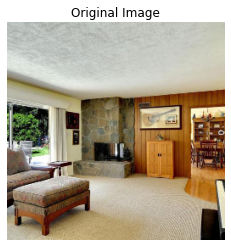

Inference Time: 0.22993826866149902


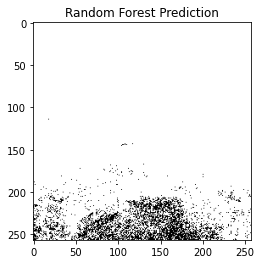

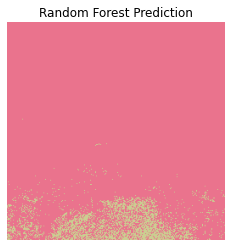

51810
[0 1]
[0 1]


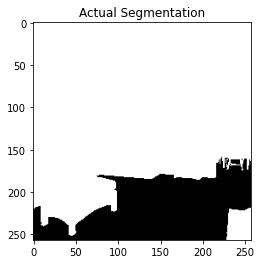

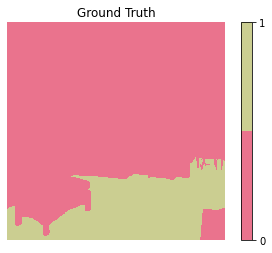

Random Forest Pixel Accuracy on the test image =  0.8331995942406395
Random Forest Confusion Matrix on the test image =  [[51453   357]
 [10660  3579]]
3579 51453 357 10660
Random Forest Recall on the test image =  0.2513519207809537


In [24]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")


def test_random_forest_demo():
    ''' Test the random forest on an instance of the test dataset '''
    instance = 682 
    #instance = 683

    normalized_image = get_normalized_image(instance=instance,
                                            dataset=ADE_DIR, 
                                            target_width=TARGET_WIDTH,
                                            target_height=TARGET_HEIGHT)
    normalized_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)
    plt.imshow(normalized_image)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

    with open(os.path.join(MODELS, r"random_forest_256_257.sav"), 'rb') as f:
        model = pickle.load(f)


    instance_np = create_instance(instance=instance, dataset=ADE_DIR)
    test_df = convert_np_to_df(instance_np)

    Y_test = test_df['class']
    X_test = test_df.drop(labels=['class'], axis=1)

    start = time.time()
    prediction_test = model.predict(X_test).reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    prediction_test -= 1
    end = time.time()
    print("Inference Time: {}".format(end-start))

    plt.imshow(prediction_test, cmap='gray', vmin=0, vmax=1)
    plt.title("Random Forest Prediction")
    plt.show()
    
    
    predicted_colored = label_to_color_image(prediction_test[:,:,0])
    plt.imshow(predicted_colored)
    plt.axis('off')
    plt.title("Random Forest Prediction")
    plt.show()
    
    
    Y_test = Y_test.to_numpy().reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    print(Y_test.sum())
    #print(Y_test)
    plt.imshow(Y_test, cmap='gray', vmin=0, vmax=1)
    
    '''
    acutal_colored = label_to_color_image(Y_test[:,:,0])
    plt.title("Actual Segmentation")
    plt.show()
    plt.axis('off')
    cmap = colors.ListedColormap(['#CBCE91', '#EA738DFF'])
    bounds=[0,0.5,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    seg_image = plt.imshow(Y_test, cmap=cmap, norm=norm)
    plt.colorbar(seg_image, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0,1])
    plt.title("Ground Truth")
    plt.show()
    '''
    
    print(np.unique(Y_test[:,:,0]))
    print(np.unique(1-Y_test[:,:,0]))
    acutal_colored = label_to_color_image(1-Y_test[:,:,0])
    plt.title("Actual Segmentation")
    plt.show()
    plt.axis('off')
    #cmap = colors.ListedColormap(['#CBCE91', '#EA738DFF'])
    cmap = colors.ListedColormap(['#EA738DFF', '#CBCE91'])
    bounds=[0,0.5,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    seg_image = plt.imshow(1-Y_test[:,:,0], cmap=cmap, norm=norm)
    plt.colorbar(seg_image, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0,1])
    plt.title("Ground Truth")
    plt.show()
    
    

    print("Random Forest Pixel Accuracy on the test image = ", metrics.accuracy_score(1-Y_test.flatten(), 1-prediction_test.flatten()))
    
    #cm = metrics.confusion_matrix(1-Y_test.flatten(), 1-prediction_test.flatten())
    cm = metrics.confusion_matrix(1-Y_test.flatten(), 1-prediction_test.flatten())
    tn, fp, fn, tp = cm.ravel()
    print("Random Forest Confusion Matrix on the test image = ", cm)
    print(tp, tn, fp, fn)
    
    print("Random Forest Recall on the test image = ", metrics.recall_score(1-Y_test.flatten(), 1-prediction_test.flatten()))


    
test_random_forest_demo()




74524
1903290
69011
132792
Random Forest Pixel Accuracy on the test image = 0.9074135501787699
Random Forest Recall on the test image = 0.35947056667116867
Random Forest Precision on the test image = 0.5192043752394886
Random Forest Jaccard Score on the test image = 0.26969496285198336
Random Forest ROC AUC on the test image = 0.6622402356729811
[0.        0.0349901 1.       ]
[0.         0.35947057 1.        ]


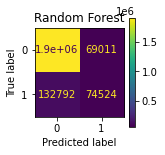

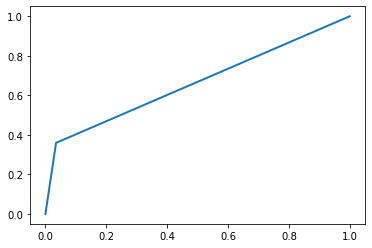

List of Importance Features from Random Forest Model:
row                0.271033
col                0.067855
red                0.067195
blue               0.059028
gaussian_7         0.047816
green              0.041741
sobel              0.037682
median_16          0.035572
median_4           0.031157
gaussian_3         0.028654
gray               0.026117
gabor_6            0.023392
gabor_5            0.020649
gabor_30           0.020574
gabor_7            0.020019
gabor_23           0.019801
laplace_reflect    0.019718
gabor_20           0.019705
gabor_31           0.019556
gabor_28           0.018665
gabor_4            0.017807
gabor_29           0.017592
gabor_22           0.016999
gabor_21           0.010401
gabor_11           0.009733
gabor_3            0.009472
gabor_10           0.007770
gabor_2            0.004180
canny              0.002252
gabor_27           0.002069
gabor_19           0.001961
gabor_26           0.001430
gabor_14           0.000587
gabor_13           0.0

In [35]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")

''' 
The test_df from instances gives 0 1
The test_df from the actual test_df gives 1 2
'''
def test_random_forest_fast():
    with open(os.path.join(MODELS, r"random_forest_256_257.sav"), 'rb') as f:
        model = pickle.load(f)
    
    test_df = pd.read_csv(os.path.join(DATAFRAMES, "test.csv"))
    num_instances = test_df.shape[0]//(TARGET_HEIGHT*TARGET_WIDTH)

    Y_test = test_df['class'] # Original shape
    X_test = test_df.drop(labels=['class'], axis=1)
    
    prediction_test = model.predict(X_test).reshape((num_instances, TARGET_HEIGHT, TARGET_WIDTH, -1))
    prediction_test -= 1 # Remap from [1,2] to [0,1]
    Y_test = Y_test.to_numpy().reshape((num_instances, TARGET_HEIGHT, TARGET_WIDTH, -1))
    Y_test -= 1 # Remap from [1,2] to [0,1]

       # Flip so that 0 can be obstacle and 1 can be non-obstacle
    Y_test_final = 1-Y_test.flatten()
    predict_test_final = 1-prediction_test.flatten()
    
    cm = confusion_matrix(Y_test_final, predict_test_final)
    tn, fp, fn, tp = cm.ravel()


    display_metrics(
        name="Random Forest",
        true_positives=tp,
        true_negatives=tn,
        false_positives=fp,
        false_negatives=fn,
        pixel_accuracy=metrics.accuracy_score(Y_test_final, predict_test_final),
        recall=metrics.recall_score(Y_test_final, predict_test_final),
        precision=metrics.precision_score(Y_test_final, predict_test_final),
        jaccard=metrics.jaccard_score(Y_test_final, predict_test_final),
        roc_auc=metrics.roc_auc_score(Y_test_final, predict_test_final))
    
    
    # This plots the ROC_AUC_Score but since our target classes only has two possible outputs (0 and 1), its graph is not fruitful
    # The auc score is more fruitful
 
    fpr, tpr, _ = metrics.roc_curve(Y_test_final, predict_test_final)
    print(fpr)
    print(tpr)

    auc = metrics.roc_auc_score(Y_test_final, predict_test_final)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, linewidth=2.0)
    plt.show()
   
    #
    important_features = list(model.feature_importances_)
    feature_list = list(X_test.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print("List of Importance Features from Random Forest Model:")
    print(feature_imp)

test_random_forest_fast()
# 74524/(74524+132792) = 1 - (TN/TN+FP) = 0.64052943  = fpr
#1903290/(1903290+69011) =TP/TP+FN= 0.9650099 = tpr


## Training the SVM Classifier

In [29]:
from sklearn import svm

def train_support_vector_machine():
    ''' Train SVM on the train dataset '''
    # TRAIN
    print("Reading df")
    train_df = pd.read_csv(os.path.join(DATAFRAMES, "train.csv"))
    test_df = pd.read_csv(os.path.join(DATAFRAMES, "test.csv"))

    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()
    test_df = test_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()

    train_df = train_df.drop(labels=['index'], axis=1)
    test_df = test_df.drop(labels=['index'], axis=1)

    print("Finished Reading df")

    print(train_df.shape)
    print(test_df.shape)
    print(train_df.head())
    print(test_df.head())

    Y_train = train_df['class'].values
    X_train = train_df.drop(labels=['class'], axis=1)
    model = svm.LinearSVC(random_state=RANDOM_SEED)
    print("Fitting")
    start = time.time()
    model.fit(X_train, Y_train)
    end = time.time()
    print("Time elapsed for fit: {}".format(end-start)) # 7642 seconds for 32

    with open(os.path.join(MODELS, r"svm_256_257.sav,'wb') as f:
        pickle.dump(model,f)


# train_support_vector_machine()
#Time elapsed for fit: 10720.816451787949
#Predicting
#Accuracy= 0.16469911915717303
#Time elapsed for predict: 0.7809450626373291

'\n# TRAIN\nprint("Reading df")\ntrain_df = pd.read_csv(os.path.join(DATAFRAMES, "train.csv"))\ntest_df = pd.read_csv(os.path.join(DATAFRAMES, "test.csv"))\n\ntrain_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()\ntest_df = test_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()\n\ntrain_df = train_df.drop(labels=[\'index\'], axis=1)\ntest_df = test_df.drop(labels=[\'index\'], axis=1)\n\n\nprint("Finished Reading df")\n\nprint(train_df.shape)\nprint(test_df.shape)\n\nprint(train_df.head())\nprint(test_df.head())\n\n\nY_train = train_df[\'class\'].values\nX_train = train_df.drop(labels=[\'class\'], axis=1)\nmodel = svm.LinearSVC(random_state=RANDOM_SEED)\nprint("Fitting")\nstart = time.time()\nmodel.fit(X_train, Y_train)\nend = time.time()\nprint("Time elapsed for fit: {}".format(end-start)) # 988.2334911823273 seconds for 32\n\n\nwith open(os.path.join(MODELS, r"svm_256_257.sav,\'wb\') as f:\n    pickle.dump(model,f)\n'

## Testing the SVM Classifier 

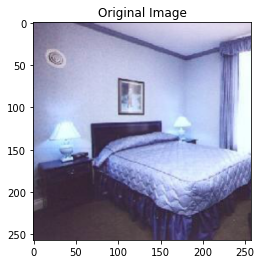

Time elapsed for prediction: 0.013993978500366211


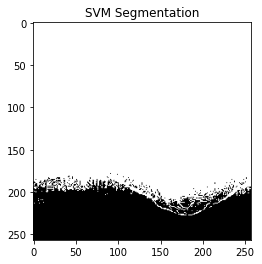

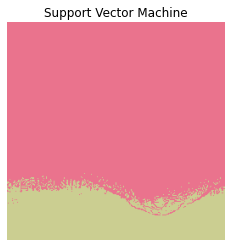

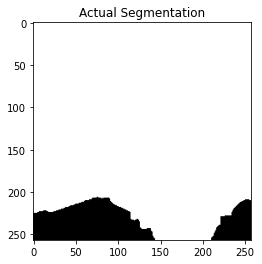

SVM Pixel Accuracy on the test image =  0.8803615497585127


In [79]:
def test_support_vector_machine_demo():
    ''' Test the svm on an instance of the test dataset '''
    #instance = 682
    instance = 3673

    normalized_image = get_normalized_image(instance=instance,
                                            dataset=ADE_DIR, 
                                            target_width=TARGET_WIDTH,
                                            target_height=TARGET_HEIGHT)
    plt.imshow(normalized_image)
    plt.title("Original Image")
    plt.show()

    with open(os.path.join(MODELS, r"svm_32_257.sav"), 'rb') as f:
        model = pickle.load(f)

    instance_np = create_instance(instance=instance, dataset=ADE_DIR)
    test_df = convert_np_to_df(instance_np)

    X_test = test_df.drop(labels=['class'], axis=1)
    Y_test = test_df['class']

    start = time.time()
    prediction_test = model.predict(X_test).reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    end = time.time()
    print("Time elapsed for prediction: {}".format(end-start)) 

    prediction_test -= 1
    plt.imshow(prediction_test, cmap='gray', vmin=0, vmax=1)
    plt.title("SVM Segmentation")
    plt.show()
    
    
    predicted_colored = label_to_color_image(prediction_test[:,:,0])
    plt.imshow(predicted_colored)
    plt.axis('off')
    plt.title("Support Vector Machine")
    plt.show()


    Y_test = Y_test.to_numpy().reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    plt.imshow(Y_test, cmap='gray', vmin=0, vmax=1)
    plt.title("Actual Segmentation")
    plt.show()


    print("SVM Pixel Accuracy on the test image = ", metrics.accuracy_score(Y_test.flatten(), prediction_test.flatten()))

    
test_support_vector_machine_demo()

## Training Logistic Regression 

In [68]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression():
    ''' Train Logisitc Regression on the train dataset '''
    # TRAIN
    print("Reading df")
    train_df = pd.read_csv(os.path.join(DATAFRAMES, "train.csv"))
    test_df = pd.read_csv(os.path.join(DATAFRAMES, "test.csv"))

    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()
    test_df = test_df.sample(frac=1, random_state=RANDOM_SEED).reset_index()

    train_df = train_df.drop(labels=['index'], axis=1)
    test_df = test_df.drop(labels=['index'], axis=1)

    print("Finished Reading df")

    print(train_df.shape)
    print(test_df.shape)

    print(train_df.head())
    print(test_df.head())

    Y_train = train_df['class'].values
    X_train = train_df.drop(labels=['class'], axis=1)

    model = LogisticRegression(random_state=RANDOM_SEED, max_iter=100)
    print("Fitting")
    start = time.time()
    model.fit(X_train, Y_train)
    end = time.time()
    print("Time elapsed for fit: {}".format(end-start)) # 282.1226978302002 seconds for 32, @ 100 max_iterations
    # ~3 hours for 256 instances

    with open(os.path.join(MODELS, r"logreg_256_257_max.sav"),'wb') as f:
        pickle.dump(model,f)
        
        
#train_logistic_regression()

## Testing the Logistict Regression Classifier 

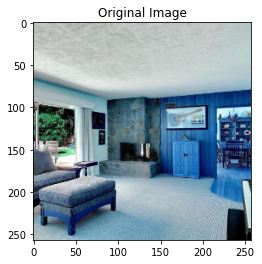

Time elapsed for prediction: 0.011174440383911133


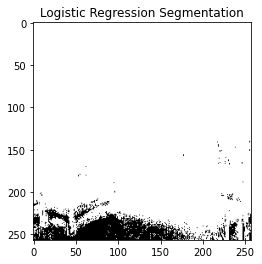

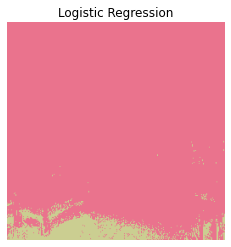

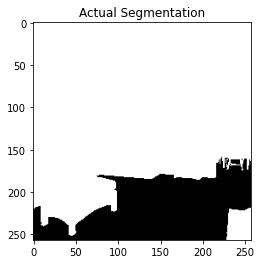

Logistic Regression Accuracy on the test image =  0.8266892761434692


In [15]:
def test_logistic_regression_demo():
    ''' Test the logistic regression on an instance of the test dataset '''
    instance = 682
    normalized_image = get_normalized_image(instance=instance,
                                            dataset=ADE_DIR, 
                                            target_width=TARGET_WIDTH,
                                            target_height=TARGET_HEIGHT)
    plt.imshow(normalized_image)
    plt.title("Original Image")
    plt.show()

    with open(os.path.join(MODELS, r"logreg_32_257_max.sav"), 'rb') as f:
        model = pickle.load(f)

    instance_np = create_instance(instance=instance, dataset=ADE_DIR)
    test_df = convert_np_to_df(instance_np)


    X_test = test_df.drop(labels=['class'], axis=1)
    Y_test = test_df['class']

    start = time.time()
    prediction_test = model.predict(X_test).reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    end = time.time()
    print("Time elapsed for prediction: {}".format(end-start)) # 282.1226978302002 seconds for 32, @ 100 max_iterations

    prediction_test -= 1
    plt.imshow(prediction_test, cmap='gray')
    plt.title("Logistic Regression Segmentation")
    plt.show()
    

    predicted_colored = label_to_color_image(prediction_test[:,:,0])
    plt.imshow(predicted_colored)
    plt.axis('off')
    plt.title("Logistic Regression")
    plt.show()
    

    Y_test = Y_test.to_numpy().reshape((TARGET_HEIGHT, TARGET_WIDTH, -1))
    plt.imshow(Y_test, cmap='gray')
    plt.title("Actual Segmentation")
    plt.show()


    print("Logistic Regression Accuracy on the test image = ", metrics.accuracy_score(Y_test.flatten(), prediction_test.flatten()))
    
test_logistic_regression_demo()

In [7]:
def machine_learning_metrics_test_dataset(model_filename, test_filename):
    ''' Test the svm on the entire test dataset '''
    with open(os.path.join(MODELS, model_filename), 'rb') as f:
        model = pickle.load(f)
    
    test_df = pd.read_csv(os.path.join(DATAFRAMES, test_filename)) # The new test256 has 0, 1
    num_instances = test_df.shape[0]//(TARGET_HEIGHT*TARGET_WIDTH)
    
    #print(test_df.shape)
    #print(test_df.head())
    #print(num_instances)

    Y_test = test_df['class'] # Original shape
    X_test = test_df.drop(labels=['class'], axis=1)
    
    prediction_test = model.predict(X_test).reshape((num_instances, TARGET_HEIGHT, TARGET_WIDTH, -1))
    prediction_test -= 1 # Remap from [1,2] to [0,1]
    #print(np.unique(prediction_test))

    Y_test = Y_test.to_numpy().reshape((num_instances, TARGET_HEIGHT, TARGET_WIDTH, -1))
    #Y_test -= 1 # Remap from [1,2] to [0,1]
    #print(np.unique(Y_test))
    
    assert(list(np.unique(Y_test))==list(np.unique(prediction_test)))

   
    # Flip so that 0 can be obstacle and 1 can be non-obstacle
    Y_test_final = 1-Y_test.flatten()
    predict_test_final = 1-prediction_test.flatten()
   
    cm = confusion_matrix(Y_test_final, predict_test_final)
    tn, fp, fn, tp = cm.ravel()
    
    display_metrics(
        name=model_filename,
        true_positives=tp,
        true_negatives=tn,
        false_positives=fp,
        false_negatives=fn,
        pixel_accuracy=metrics.accuracy_score(Y_test_final, predict_test_final),
        recall=metrics.recall_score(Y_test_final, predict_test_final),
        precision=metrics.precision_score(Y_test_final, predict_test_final),
        jaccard=metrics.jaccard_score(Y_test_final, predict_test_final),
        roc_auc=metrics.roc_auc_score(Y_test_final, predict_test_final))

logreg_32_257_max.sav True Positive on the test dataset = 543889
logreg_32_257_max.sav True Negative on the test dataset = 14046659
logreg_32_257_max.sav False Positive on the test dataset = 425783
logreg_32_257_max.sav False Negative on the test dataset = 1958262
logreg_32_257_max.sav Pixel Accuracy on the test dataset = 0.8595521553889393
logreg_32_257_max.sav Recall on the test dataset = 0.21736857607714322
logreg_32_257_max.sav Precision on the test dataset = 0.5608999744243415
logreg_32_257_max.sav Jaccard Score on the test dataset = 0.18575862707287802
logreg_32_257_max.sav ROC AUC on the test dataset = 0.5939741582622698


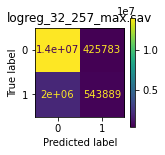

In [8]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")

machine_learning_metrics_test_dataset('logreg_32_257_max.sav', 'test_256.csv')

svm_32_257.sav True Positive on the test dataset = 1650788
svm_32_257.sav True Negative on the test dataset = 12629829
svm_32_257.sav False Positive on the test dataset = 1842613
svm_32_257.sav False Positive on the test dataset = 851363
svm_32_257.sav Pixel Accuracy on the test dataset = 0.8412936321948927
svm_32_257.sav Recall on the test dataset = 0.6597475532052223
svm_32_257.sav Precision on the test dataset = 0.47254466349554486
svm_32_257.sav Jaccard Score on the test dataset = 0.3799488303622475
svm_32_257.sav ROC AUC on the test dataset = 0.7662144093721189


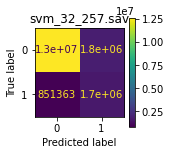

In [75]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")

machine_learning_metrics_test_dataset('svm_32_257.sav', 'test_256.csv')

random_forest_256_257.sav True Positive on the test dataset = 610621
random_forest_256_257.sav True Negative on the test dataset = 14007531
random_forest_256_257.sav False Positive on the test dataset = 464911
random_forest_256_257.sav False Positive on the test dataset = 1891530
random_forest_256_257.sav Pixel Accuracy on the test dataset = 0.8611783504912313
random_forest_256_257.sav Recall on the test dataset = 0.24403842933539982
random_forest_256_257.sav Precision on the test dataset = 0.5677385703075315
random_forest_256_257.sav Jaccard Score on the test dataset = 0.20579987880266742
random_forest_256_257.sav ROC AUC on the test dataset = 0.6059572743261874


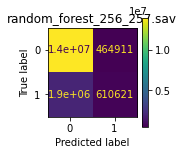

In [76]:
TRAINING_ENVIRONMENT_DIR = r"../training_environment"
RF_ADE_INDOOR_ENVIRONMENT_DIR = os.path.join(TRAINING_ENVIRONMENT_DIR, r"random_forest_ade_indoor")
DATAFRAMES = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Dataframes")
MODELS = os.path.join(RF_ADE_INDOOR_ENVIRONMENT_DIR, r"Models")

machine_learning_metrics_test_dataset('random_forest_256_257.sav', 'test_256.csv')